In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

In [3]:
class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()
    
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x

In [4]:
df = pd.read_pickle('../data/LP_Simulations_Formatted.pkl')
window_size = 100
stride = 20
df

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02


In [5]:
# first lets split the dataframe into a train and test set using the Subject column. Keep subjects separate during training and testing
#df = dd.from_pandas(df, npartitions=4)
subject_dfs = split_df_into_subjects(df)
train_split = 0.9
n_train_subjects = int(len(subject_dfs) * train_split)
n_test_subjects = len(subject_dfs) - n_train_subjects


In [6]:
n_test_subjects, n_train_subjects

(52, 466)

In [7]:
# randomly pick the subjects to use for training and testing
train_subjects_index = np.random.choice(len(subject_dfs), n_train_subjects, replace=False)
train_df = pd.concat([subject_dfs[i] for i in train_subjects_index])
test_df = pd.concat([subject_dfs[i] for i in range(len(subject_dfs)) if i not in train_subjects_index])


In [8]:
train_data = Dataset_LSTM(train_df, sort_column=['Subject'], window_size=window_size, stride=stride)

In [9]:
test_data = Dataset_LSTM(test_df, sort_column=['Subject'], window_size=window_size, stride=stride)

In [10]:
train_data.X.shape, test_data.X.shape

((35910, 100, 8), (3654, 100, 8))

In [11]:
train_data.X = torch.from_numpy(train_data.X).float()
train_data.Y = torch.from_numpy(train_data.Y).float()
test_data.X = torch.from_numpy(test_data.X).float()
test_data.Y = torch.from_numpy(test_data.Y).float()

In [12]:
train_data[0]

(tensor([[0.0379, 0.0361, 0.1258, 0.0260, 0.0326, 0.0477, 0.0219, 0.1759],
         [0.0388, 0.0358, 0.1304, 0.0258, 0.0325, 0.0480, 0.0219, 0.1756],
         [0.0399, 0.0356, 0.1344, 0.0256, 0.0319, 0.0483, 0.0220, 0.1647],
         [0.0409, 0.0354, 0.1385, 0.0255, 0.0310, 0.0486, 0.0220, 0.1499],
         [0.0419, 0.0353, 0.1410, 0.0253, 0.0299, 0.0486, 0.0219, 0.1371],
         [0.0423, 0.0351, 0.1415, 0.0251, 0.0289, 0.0484, 0.0219, 0.1339],
         [0.0428, 0.0350, 0.1444, 0.0250, 0.0280, 0.0486, 0.0219, 0.1324],
         [0.0435, 0.0351, 0.1478, 0.0249, 0.0269, 0.0490, 0.0220, 0.1288],
         [0.0448, 0.0354, 0.1542, 0.0247, 0.0258, 0.0502, 0.0227, 0.1212],
         [0.0464, 0.0356, 0.1615, 0.0246, 0.0249, 0.0517, 0.0234, 0.1110],
         [0.0479, 0.0357, 0.1667, 0.0245, 0.0242, 0.0532, 0.0240, 0.0993],
         [0.0495, 0.0357, 0.1719, 0.0245, 0.0236, 0.0546, 0.0242, 0.0873],
         [0.0507, 0.0356, 0.1751, 0.0244, 0.0231, 0.0555, 0.0242, 0.0778],
         [0.0520, 0.0355,

Text(0, 0.5, 'Force')

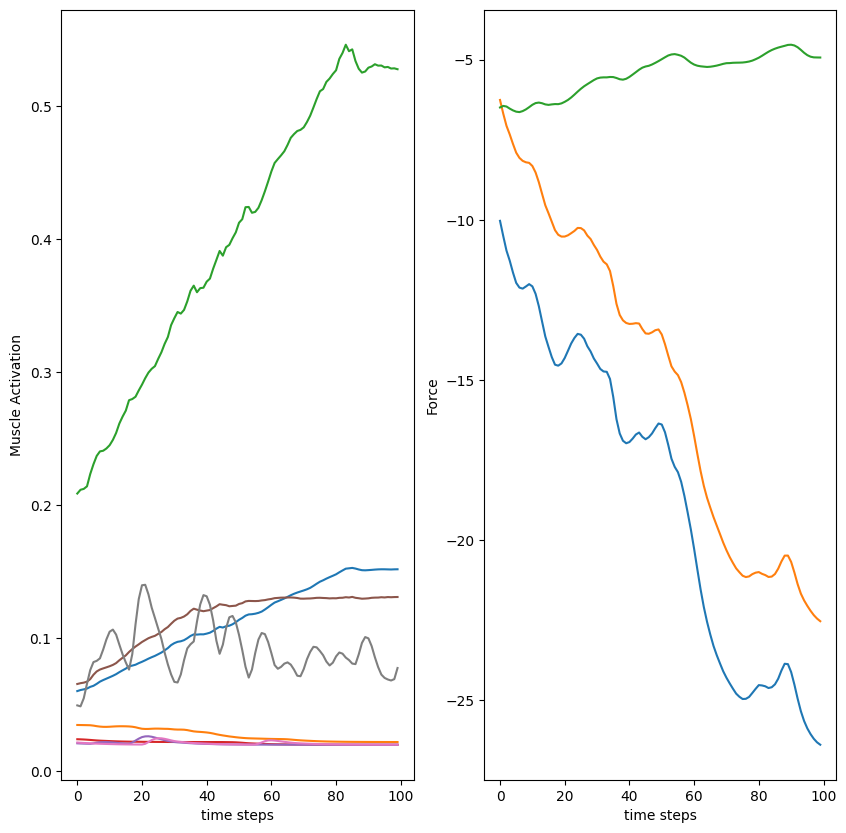

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Muscle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [15]:
#model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=8).to('cuda')
learning_rate = 0.062259
batch_size = 19
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (output): Linear(in_features=8, out_features=300, bias=True)
)

In [16]:
# PASS A SAMPLE THROUGH TO FIX THE MODEL DIMENSIONS
model(train_data.X[0:10].to('cuda'))
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (output): Linear(in_features=8, out_features=300, bias=True)
)

In [17]:
losses = kmk.run_Pytorch(model, train_data.X.reshape(-1, 100, 8), train_data.Y, n_epochs=101, batch_size=batch_size, learning_rate=learning_rate, device='cuda')

EPOCH :  0 , dt:  17.298542976379395 seconds, losses : 14.172845840454102
EPOCH :  10 , dt:  167.723397731781 seconds, losses : 23.999502182006836
EPOCH :  20 , dt:  168.58088970184326 seconds, losses : 16.918567657470703
EPOCH :  30 , dt:  166.91432428359985 seconds, losses : 17.279375076293945
EPOCH :  40 , dt:  167.7270667552948 seconds, losses : 17.6987361907959
EPOCH :  50 , dt:  172.99692392349243 seconds, losses : 17.352073669433594
EPOCH :  60 , dt:  170.0490312576294 seconds, losses : 16.47355079650879
EPOCH :  70 , dt:  171.84935879707336 seconds, losses : 16.77751922607422
EPOCH :  80 , dt:  168.73201251029968 seconds, losses : 17.014883041381836
EPOCH :  90 , dt:  172.32967019081116 seconds, losses : 18.855628967285156
EPOCH :  100 , dt:  173.69361329078674 seconds, losses : 19.05311393737793


In [18]:
# save the model state dict to the model folder
import os
# import the datetime properly
from datetime import datetime
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    # check if the model already exists and add a number to the end
    if os.path.exists('models/' + name + '.pt'):
        i = 0
        while os.path.exists('models/' + name + str(i) + '.pt'):
            i += 1
        torch.save(model.state_dict(), 'models/' + name + str(i) + '.pt')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'lstm_3layer_30nodes_200epochs_' + str(datetime.now().date()))

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

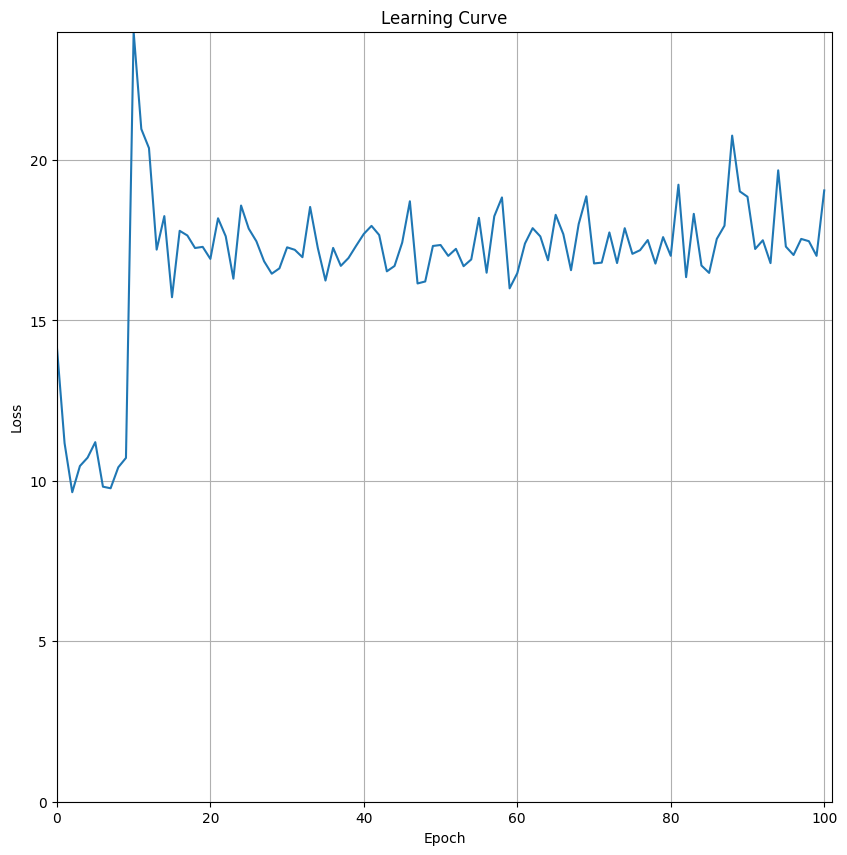

In [19]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

In [22]:
import gc
def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [23]:
torch.cuda.empty_cache()
gc.collect()
batch_predict(model, train_data.X.to('cuda'))

tensor([[-10.9954,  -8.3151,  -5.3929,  ..., -18.8777, -15.5744,  -3.6900],
        [-13.4761, -10.5525,  -4.1144,  ..., -22.2678, -18.7472,  -2.3735],
        [-15.2846, -11.6503,  -3.1663,  ..., -24.4694, -20.1226,  -1.3253],
        ...,
        [-17.7973, -12.7757,  -1.8371,  ..., -27.3257, -21.3304,   0.1973],
        [-19.3158, -13.4558,  -1.0338,  ..., -29.0518, -22.0602,   1.1174],
        [-19.8539, -13.6968,  -0.7491,  ..., -29.6636, -22.3189,   1.4435]])

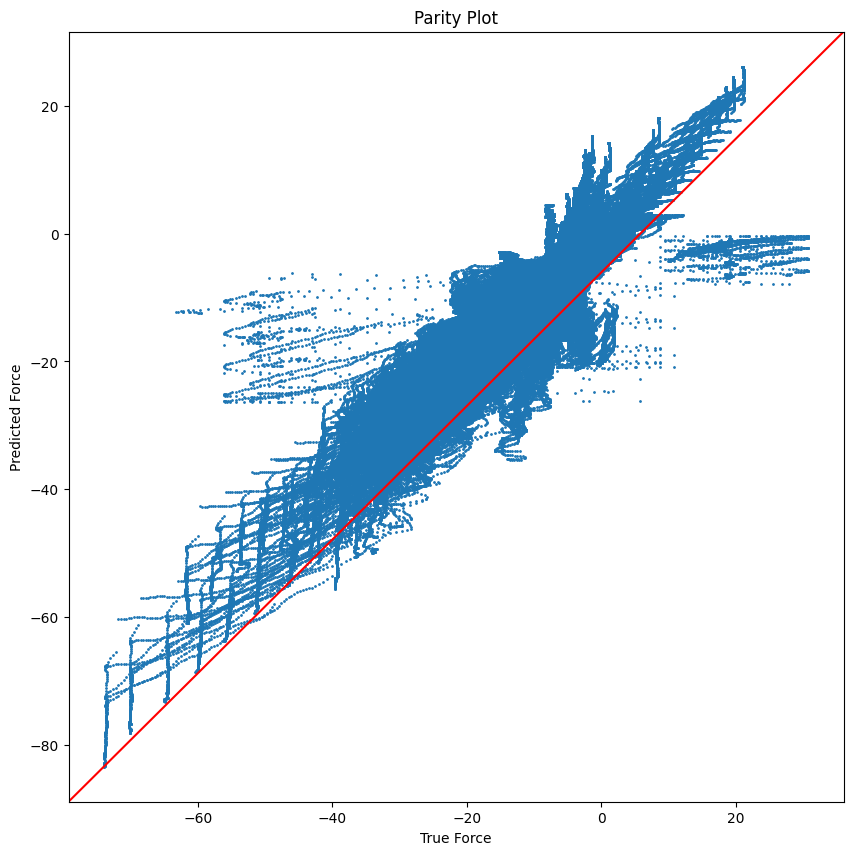

In [24]:
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten(), pred.flatten())
mae = mean_absolute_error(test_data.Y.flatten(), pred.flatten())
mse = mean_squared_error(test_data.Y.flatten(), pred.flatten())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.8176065468518843 mae:  2.5794199 mse:  13.334561


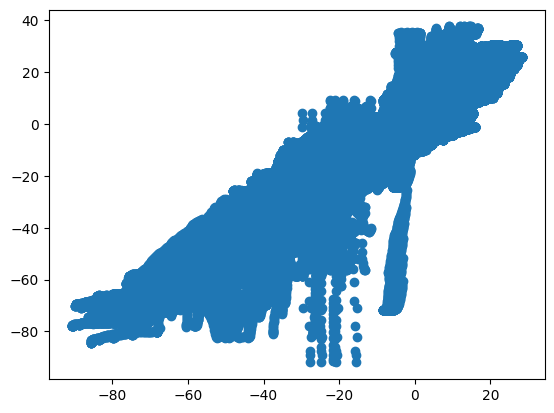

In [26]:
model = model.to('cuda')
pred_train = batch_predict(model, train_data.X.to('cuda'), batch_size=256*16).reshape(-1,1)
y_train = train_data.Y.float().detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred_train, y_train)



In [27]:
r2 = r2_score(y_train, pred_train.flatten())
mae = mean_absolute_error(y_train, pred_train.flatten())
mse = mean_squared_error(y_train, pred_train.flatten())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)

r2:  0.8458530005619729 mae:  2.8122857 mse:  15.768155


In [56]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))

<All keys matched successfully>

(100, 3)
[-16.173914 -10.852076  -4.117648]


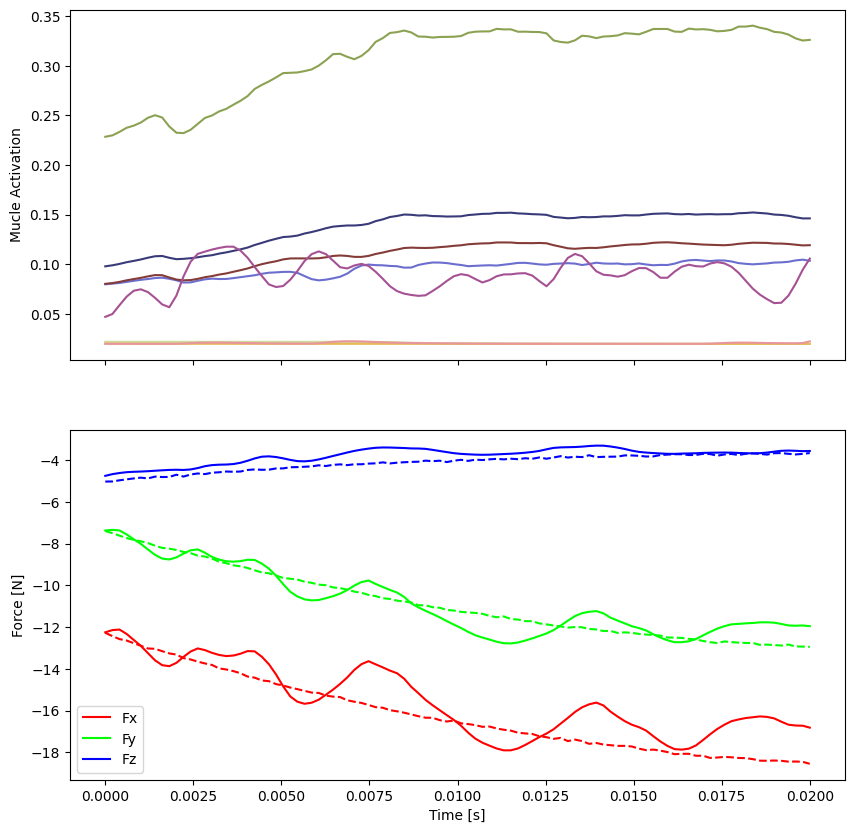

In [62]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(test_data.X))
x_plot = torch.from_numpy(test_data.X[n].cpu().numpy()).float().detach().cpu().numpy()
y_plot = test_data.Y[n].float().detach().cpu().numpy().reshape(-1, 3)
time = np.linspace(0, 2/window_size, len(x_plot))
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols


# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = model(test_data.X[n].float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)


In [63]:
kmk.TLLSTM(model, train_data.X[0:10], change_layers=2)

AttributeError: 'lstm' object has no attribute 'lstm_layers'

: 

In [37]:
# lets turn all this into a function

def get_event_prediction(event_df, reg, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = stride)
    
    # scale all the x values
    window_Xs = [i[xcols].to_numpy() for i in window_dfs]
    print(window_Xs[0].shape)
    # get the prediciton for each window
    preds = [reg(torch.from_numpy(x).float().to('cuda')).detach().cpu().numpy() for x in window_Xs]
    print(preds)
    # add the prediciton to the dataframe
    for i, temp in enumerate(window_dfs):
        temp[ycols[0]+'_pred'] = preds[i][:,0]
        temp[ycols[1]+'_pred'] = preds[i][:,1]
        temp[ycols[2]+'_pred'] = preds[i][:,2]
    # average all time points
    group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()
    # make time a column and remove the index
    group_df['Time'] = group_df.index
    group_df = group_df.reset_index(drop=True)
    return group_df

def plot_event_prediction(event_df, reg, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    group_df = get_event_prediction(event_df, reg, window_size = window_size, stride=stride, xcols = xcols, ycols = ycols, device=device)
    # plot the data
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].plot(group_df[xcols])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Muscle Activation')
    ax[1].plot(group_df[ycols])
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Force')
    ax[1].legend(ycols)
    #plot the prediction of this sample
    for i in ycols:
        ax[1].plot(group_df[i+'_pred'], '--')
    return group_df, 

7
52
(204, 8)
[array([[-0.08739211, -0.09068862, -0.37878016, ..., -0.2503793 ,
         0.09019971, -0.16994244],
       [-0.07815334, -0.08043242, -0.37546998, ..., -0.2421762 ,
         0.09486707, -0.15826547],
       [-0.0718651 , -0.07548371, -0.37568426, ..., -0.23902693,
         0.09792716, -0.1518781 ],
       ...,
       [-0.05449237, -0.06366616, -0.42143404, ..., -0.32542485,
         0.02341998, -0.21546982],
       [-0.05390704, -0.06322284, -0.4219985 , ..., -0.3256602 ,
         0.02283756, -0.21589491],
       [-0.05337285, -0.06273255, -0.4225238 , ..., -0.32601702,
         0.02229993, -0.21627365]], dtype=float32)]


C:\Users\efons\AppData\Local\Temp\ipykernel_24848\1304914789.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()


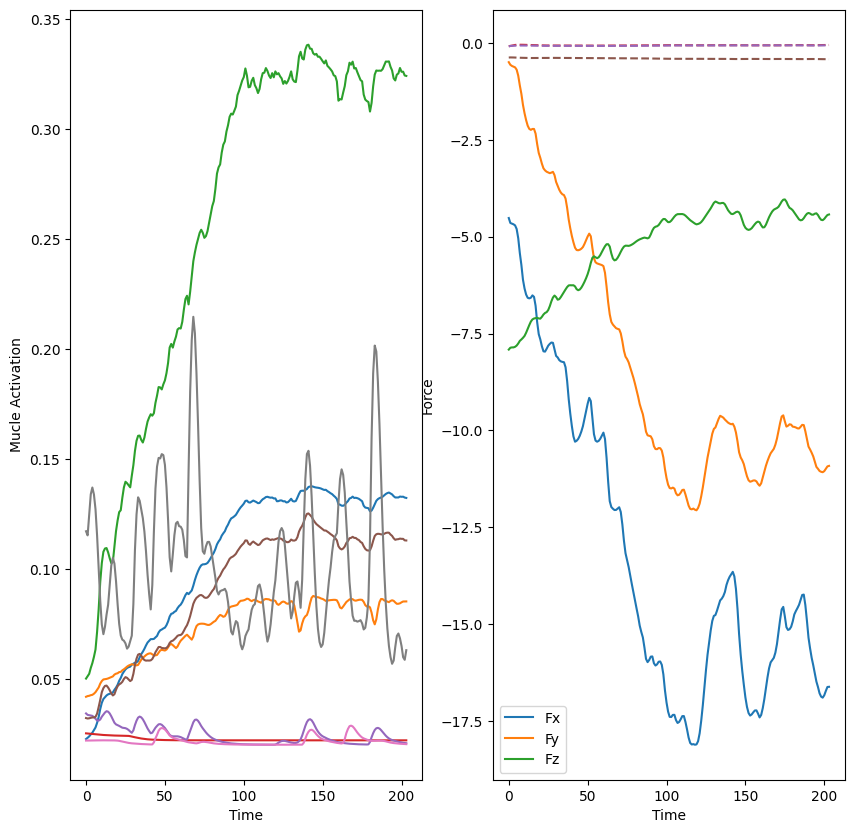

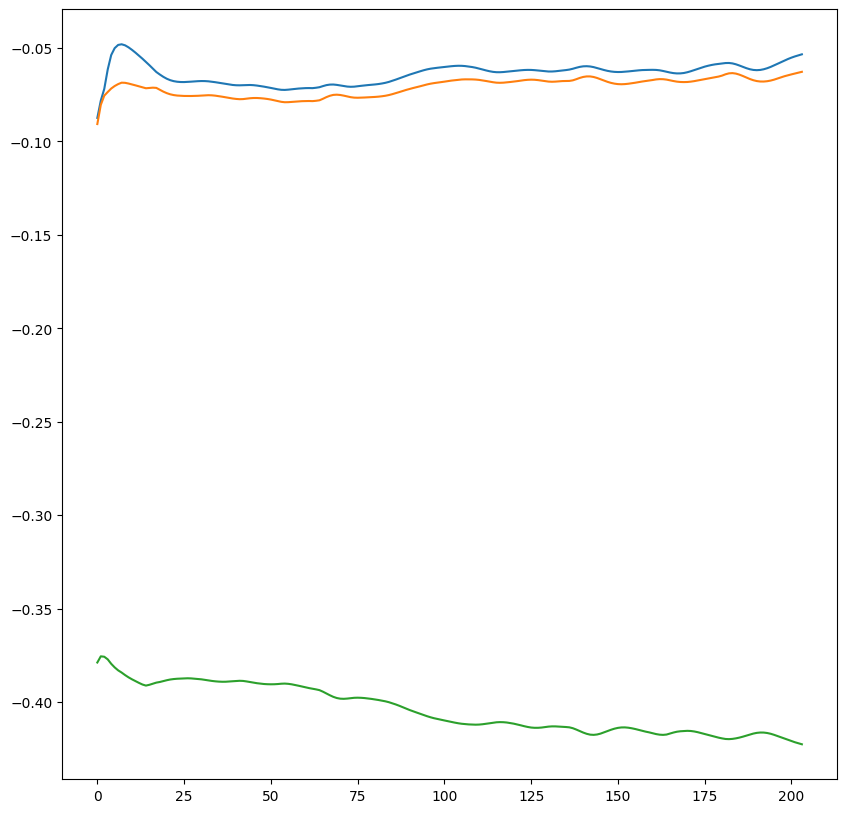

In [55]:
n = np.random.randint(0, len(test_data.subject_events))
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))
print(n)
print(len(test_data.subject_events))
subject_events = test_data.subject_events[n]
j = np.random.randint(0, len(subject_events))
group_df = plot_event_prediction(test_data.subject_events[n][j], model, window_size = 100, stride = 50, xcols=test_data.xcols, ycols=test_data.ycols, device='cuda')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(group_df[0]['Fx_pred'])
ax.plot(group_df[0]['Fy_pred'])
ax.plot(group_df[0]['Fz_pred'])

In [46]:
model

<All keys matched successfully>

In [ ]:
group_df

In [ ]:
test_data.subject_events[0]

In [ ]:
plt.plot(group_df['Time'], group_df['Fy'])
plt.plot(group_df['Time'], group_df['Fy_pred'])

In [ ]:
preds[0].shape

In [ ]:
plot_df.plot(x='Time', y='Fx')

In [ ]:
plt.plot(pred_plot[0]['Fx_pred'])

In [34]:
model2 = torch.load(r'.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt')

In [35]:
model2

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-1.1456e-01,  1.6679e-01, -6.2325e-02, -3.8305e-01,  6.1372e-02,
                       -2.0783e-02, -1.3777e-02, -8.9275e-02],
                      [ 2.1647e-01, -1.0885e-01,  7.7245e-03,  1.5067e-01,  2.7489e-02,
                       -7.0177e-03,  1.6972e-01,  1.7676e-01],
                      [ 1.9190e-01,  9.7472e-02,  2.3868e-01,  1.4518e-01,  1.7196e-01,
                        1.0203e-01,  7.6382e-02,  2.8344e-01],
                      [ 2.5878e-01, -2.5600e-02,  2.4291e-02,  2.2748e-01, -6.5862e-03,
                        9.6928e-02,  1.6938e-01, -7.2578e-02],
                      [ 1.3285e-01,  4.7278e-01,  1.8968e-01,  1.1338e-01,  2.3198e-02,
                       -2.7698e-01,  6.0285e-02,  2.1663e-01],
                      [ 9.7123e-02,  2.1430e-02,  1.5959e-01,  5.5278e-01,  9.2150e-02,
                        7.0289e-02,  1.2028e-01,  2.3837e-01],
                      [ 1.3994e-02,  5.8145e-02,  6.4217e-0

In [36]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-1.1753e-01,  1.7031e-01, -6.3710e-02, -3.9214e-01,  6.5119e-02,
                       -1.8669e-02, -1.2828e-02, -8.6344e-02],
                      [ 2.1696e-01, -1.0506e-01,  9.8458e-03,  1.6228e-01,  2.3861e-02,
                       -1.0963e-02,  1.6994e-01,  1.8477e-01],
                      [ 1.9772e-01,  1.1830e-01,  2.4268e-01,  1.2544e-01,  1.8311e-01,
                        1.1706e-01,  8.0023e-02,  2.9175e-01],
                      [ 2.6425e-01, -2.1936e-02,  2.5205e-02,  2.3722e-01, -9.2642e-03,
                        9.3072e-02,  1.6946e-01, -6.9804e-02],
                      [ 1.3601e-01,  4.7751e-01,  1.8867e-01,  1.1483e-01,  2.9002e-02,
                       -2.7524e-01,  6.3494e-02,  2.2105e-01],
                      [ 9.9849e-02,  1.6717e-02,  1.5851e-01,  5.6144e-01,  8.0335e-02,
                        6.2815e-02,  1.2022e-01,  2.4300e-01],
                      [ 8.9463e-03,  6.2977e-02,  6.2834e-0